# 0. Imports

In [1]:
import random
import sys

import joblib
import numpy as np
import pandas as pd
import shap
from tqdm import tqdm

sys.path.append("../src/")

import random
import warnings

import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from utils import generate_dataframe_for_evaluation

random.seed(0)

In [2]:
model = joblib.load("../models/optimized_lgbm_model.pkl")

In [3]:
df = pd.read_csv("../data/dataset_generated_by_extrucal.csv")

In [4]:
# Apply log-transformation to target
df["log_throughput"] = np.log1p(df["throughput"])

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

In [6]:
train_df, eval_df = train_test_split(train_df, test_size=0.2, random_state=123)

In [7]:
X_train = train_df.drop(columns=["throughput", "log_throughput"])
y_train = train_df["log_throughput"]

X_eval = eval_df.drop(columns=["throughput", "log_throughput"])
y_eval = eval_df["log_throughput"]

X_test = test_df.drop(columns=["throughput", "log_throughput"])
y_test = test_df["log_throughput"]

In [8]:
no_log_features = ["extruder_size", "polymer_density", "rpm", "number_flight"]
log_features = ["metering_depth", "screw_pitch", "flight_width"]

In [9]:
no_log_transformer = make_pipeline(
    StandardScaler(),
)

In [10]:
log_transformer = make_pipeline(
    FunctionTransformer(np.log1p),
    StandardScaler(),
)

In [11]:
preprocessor = make_column_transformer(
    (no_log_transformer, no_log_features), (log_transformer, log_features)
)

In [12]:
X_test_enc = preprocessor.fit_transform(X_test)

In [13]:
columns = (
    model.named_steps["columntransformer"]
    .named_transformers_["pipeline-1"]
    .named_steps["standardscaler"]
    .get_feature_names_out()
    .tolist()
    + model.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .named_steps["standardscaler"]
    .get_feature_names_out()
    .tolist()
)

In [14]:
X_test_enc_df = pd.DataFrame(X_test_enc, columns=columns, index=X_test.index)

In [15]:
shap.initjs()

In [16]:
lgbm_explainer = shap.Explainer(model.named_steps["lgbmregressor"])

In [17]:
shap_values = lgbm_explainer(X_test_enc_df)

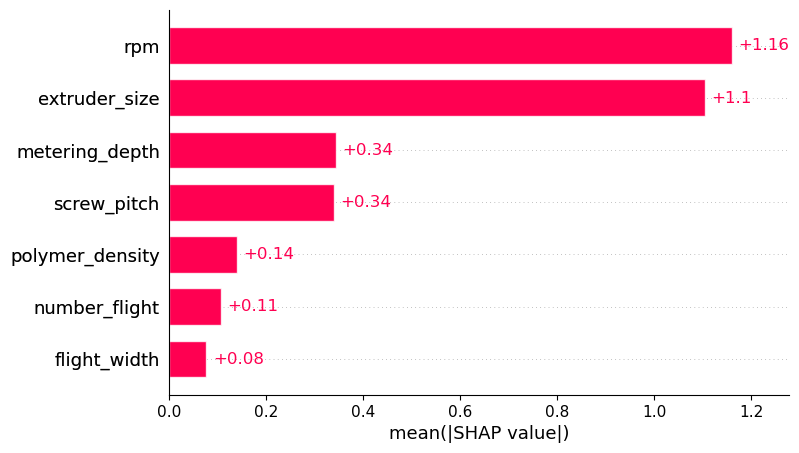

In [18]:
shap.plots.bar(shap_values, max_display=20)

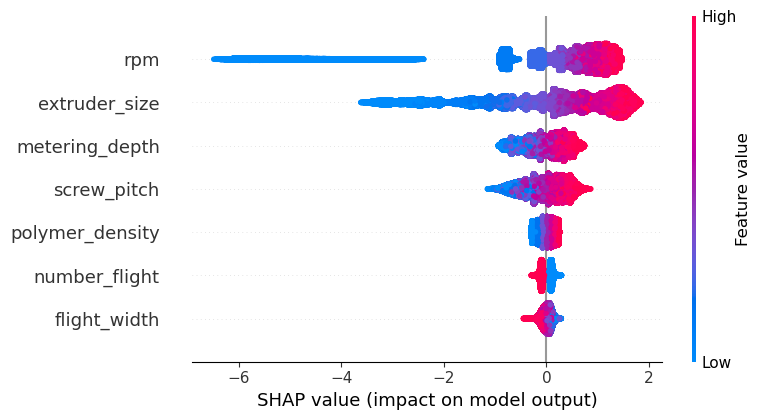

In [19]:
shap.summary_plot(shap_values)

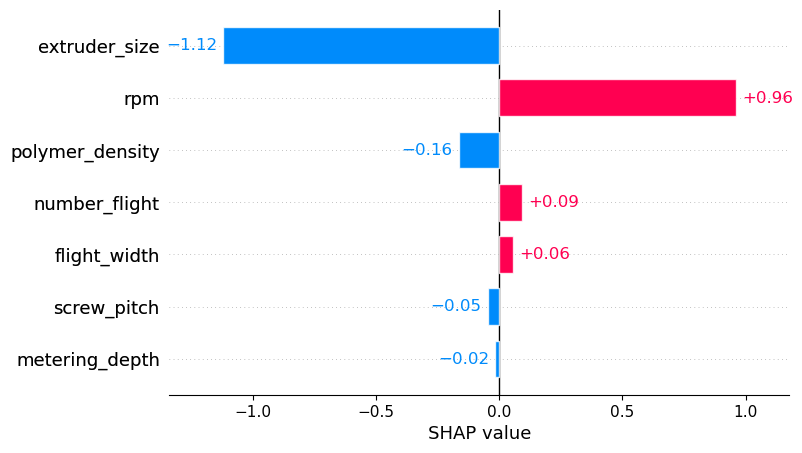

In [20]:
shap.plots.bar(shap_values[1000], max_display=20)

# 3. Conclusion

In the beginning, this study started with a simple purpose of just demonstrating that machine learning model can learn very complicated pattern and can perform as well as an analytical solution. However, while I was working on modeling, I found out that the model didn't perform well for the smallest extruder (i.e. 25mm). Initially, I thought that it was due to the fact that the throughputs at zero screw RPM were included in the train data. I also suspected that either the log transformation of the throughput might have affected the performance of the model (because the distribution of throughputs after log transformation looked really weird) or the throughputs of the 25mm extruder were just too small to be considered significant by the model. In the end, it was clear that, since `CatBoostRegresser`, which is a tree-based model, was used, the errors for the `extruder_size` that were not included in the train data were higher than those sizes that were included in the train data. In conclusion, it should be noted again that one should always be careful with the data which are not included in the train data, while predicting using tree-based models.